### Importing libraries 

In [38]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns


### Loading the data

In [39]:
# Load datasets
test_data = pd.read_csv('./data/exoTest.csv').fillna(0)
train_data = pd.read_csv('./data/exoTrain.csv').fillna(0)

# Label encoding (converting labels to binary values)
categ = {2: 1, 1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]


### Function to reduce memory storage

In [40]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# Reduce memory usage for the datasets
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)


Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


### Visualizing class distributions

Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

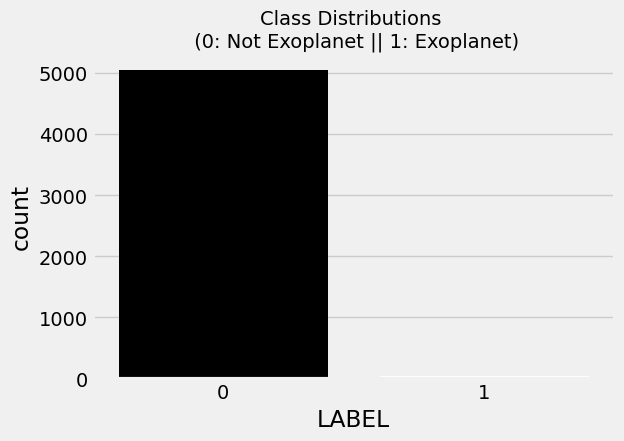

In [41]:
# Visualization of the class distributions
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette=colors)  # Corrected: passing 'x' instead of a positional argument
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)


### Plotting flux values for the first few samples

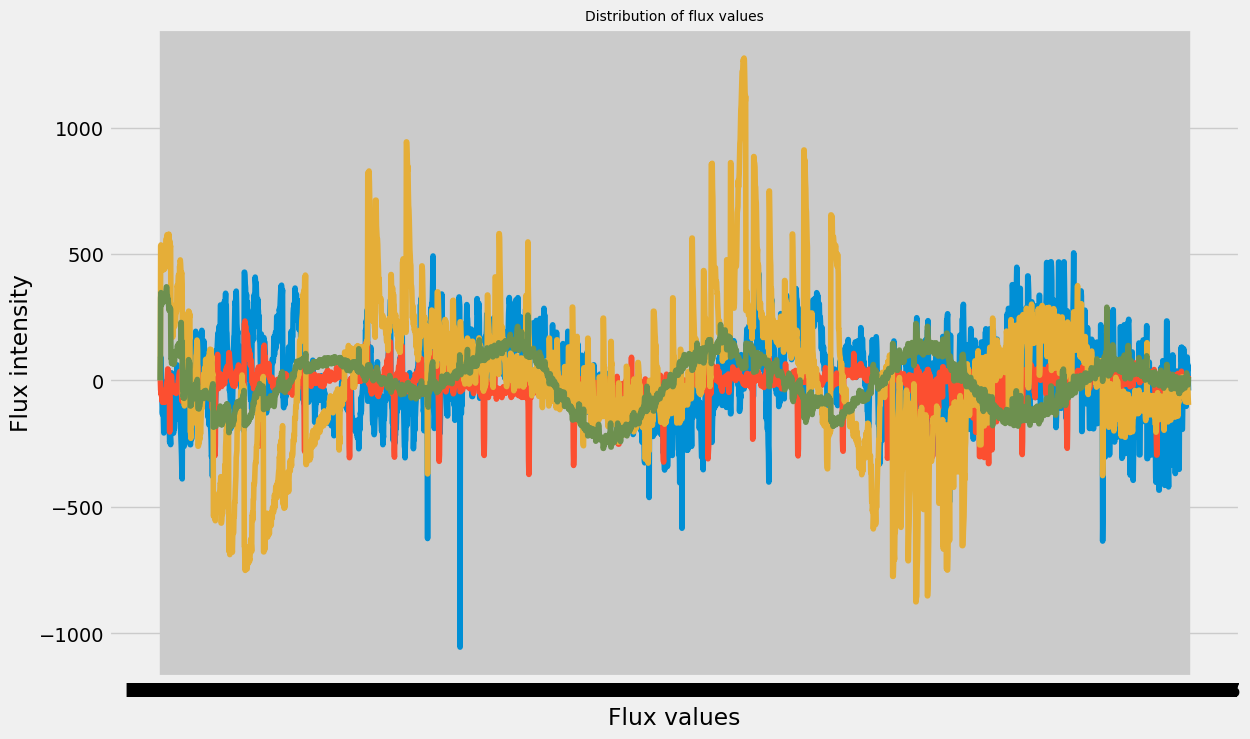

In [42]:
# Plotting the flux values for the first few samples
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()


### Gaussian histograms for non-exoplanets and exoplanets

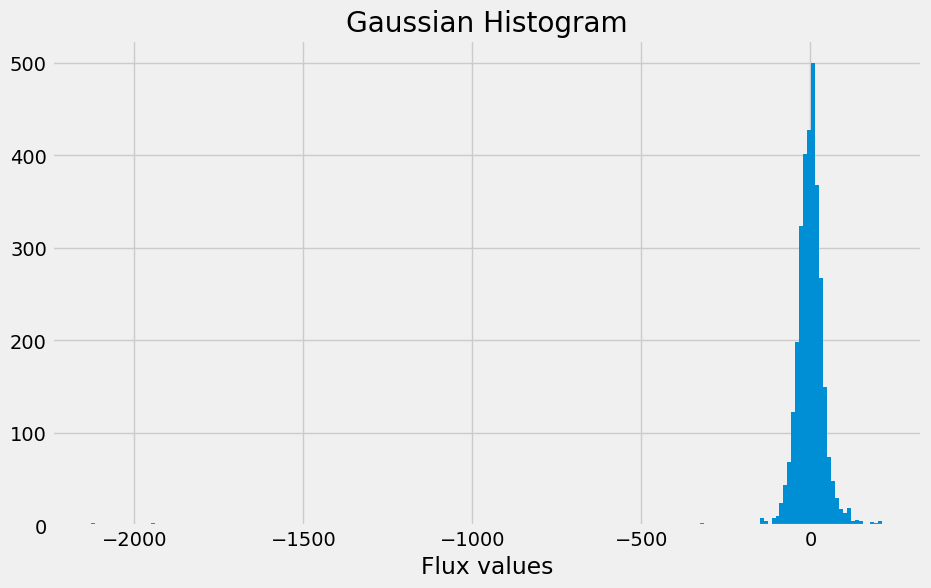

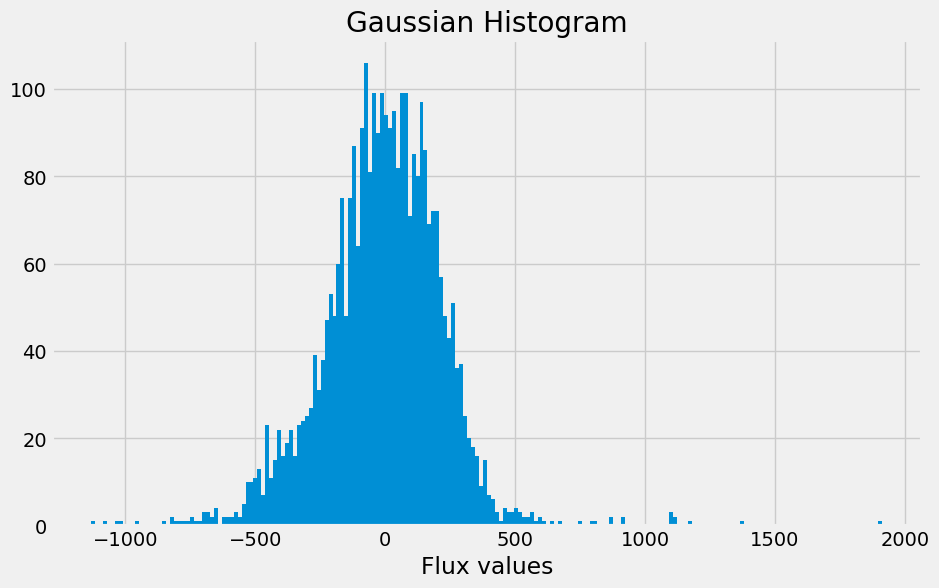

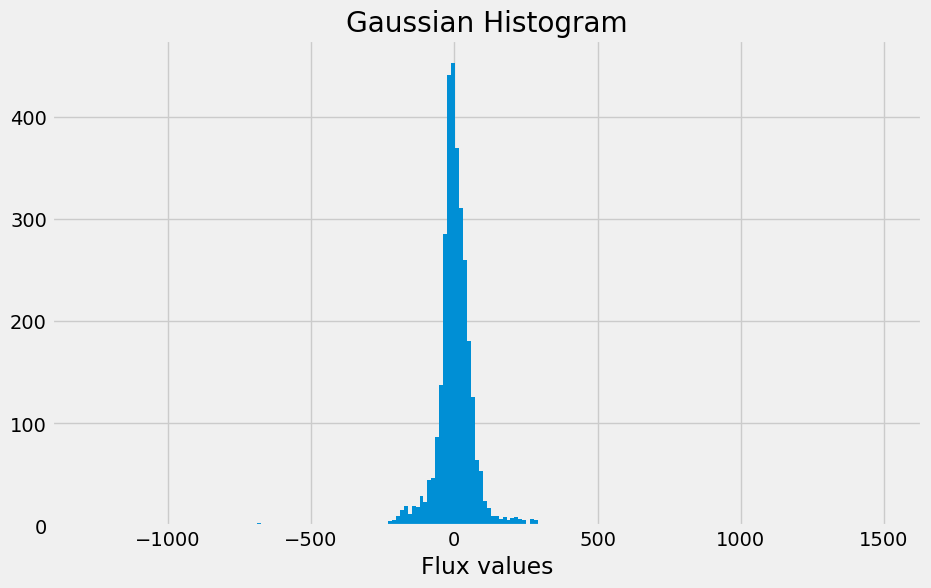

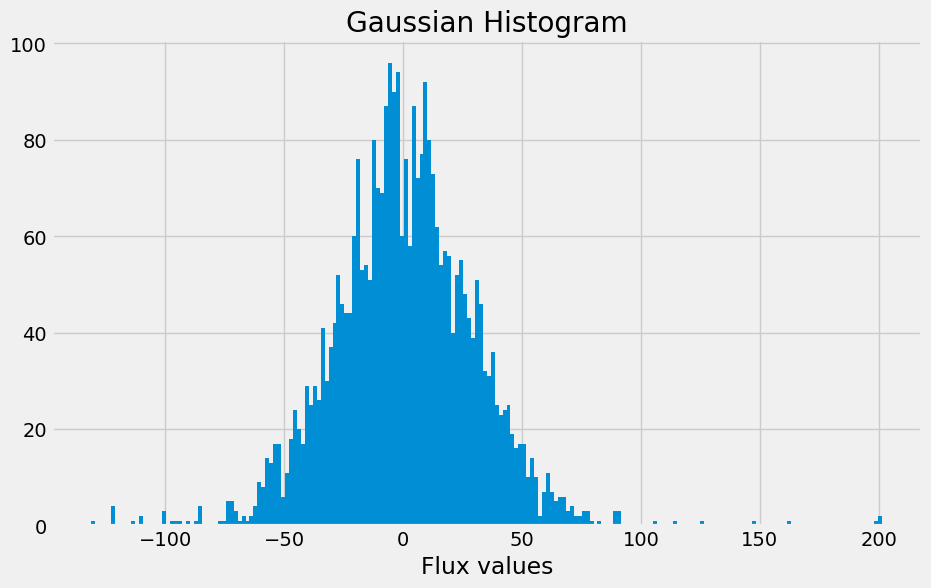

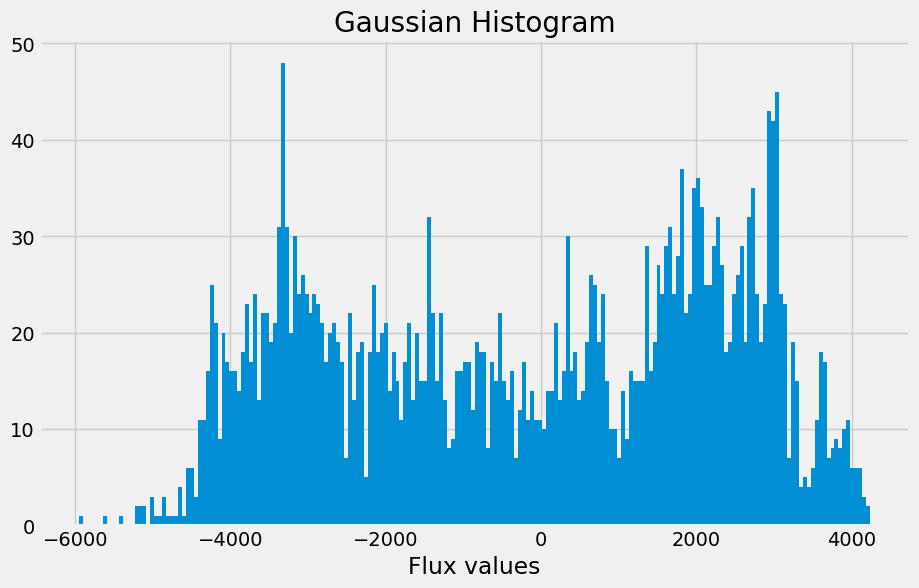

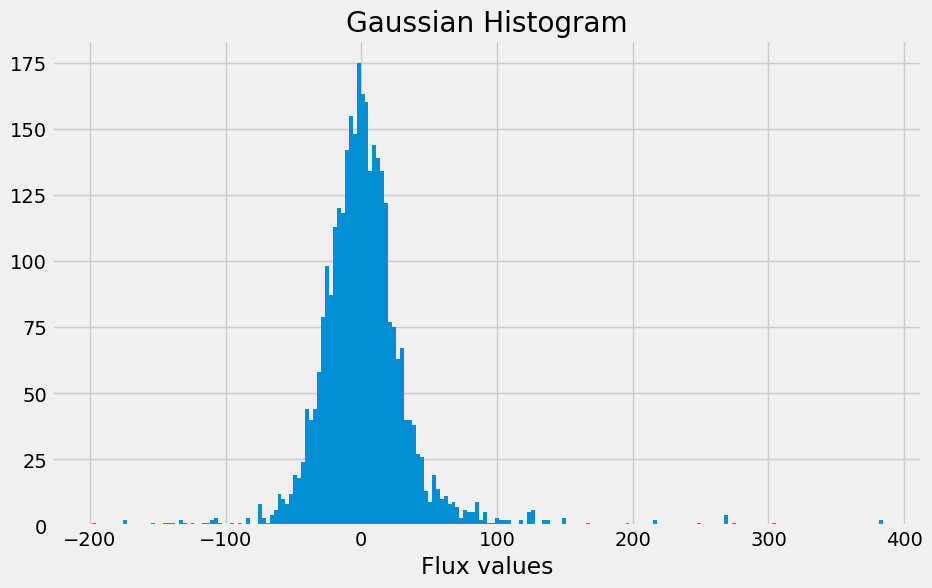

In [45]:
# Gaussian histogram for non-exoplanets
labels_1 = [100, 200, 300]
for i in labels_1:
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better display
    plt.hist(train_data.iloc[i, :], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

# Gaussian histogram for exoplanets
labels_1 = [16, 21, 25]
for i in labels_1:
    plt.figure(figsize=(10, 6))  # Adjust the figure size for better display
    plt.hist(train_data.iloc[i, :], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()


### Data preprocessing - Splitting data and normalizing

In [44]:
# Splitting the data
x_train = train_data.drop(["LABEL"], axis=1)
y_train = train_data["LABEL"]
x_test = test_data.drop(["LABEL"], axis=1)
y_test = test_data["LABEL"]

# Normalizing the data
x_train = normalize(x_train)
x_test = normalize(x_test)

# Applying Gaussian filter
x_train = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

# Feature scaling
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)


### PCA and explained variance

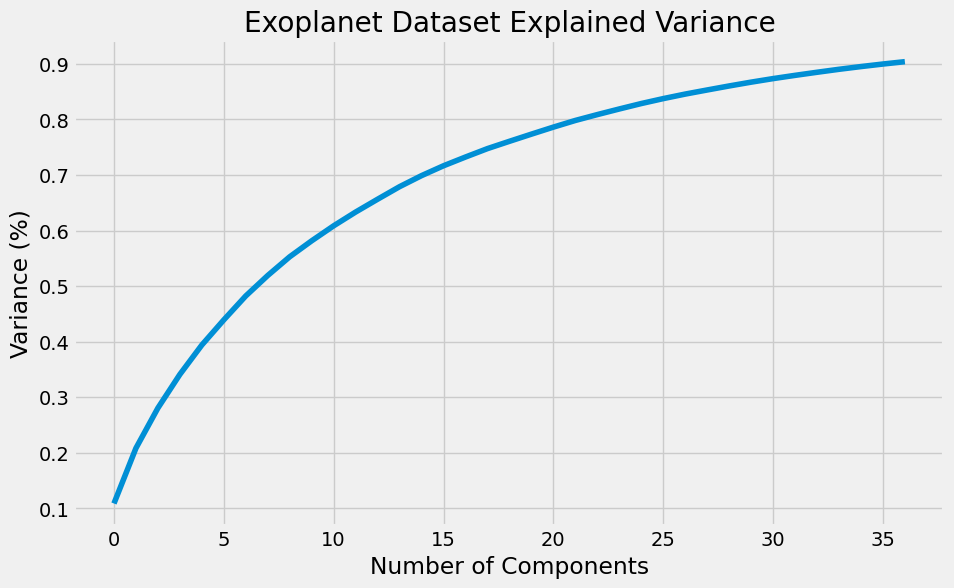

In [36]:
# Dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)

# Calculate total variance and find the number of components to retain 90% of the variance
total = sum(pca.explained_variance_)
current_variance = 0
k = 0
while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k += 1

# Apply PCA with the selected number of components
pca = PCA(n_components=k)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# Plot cumulative explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Exoplanet Dataset Explained Variance')
plt.show()


### Correlation heatmap of the components

RangeIndex(start=0, stop=37, step=1)

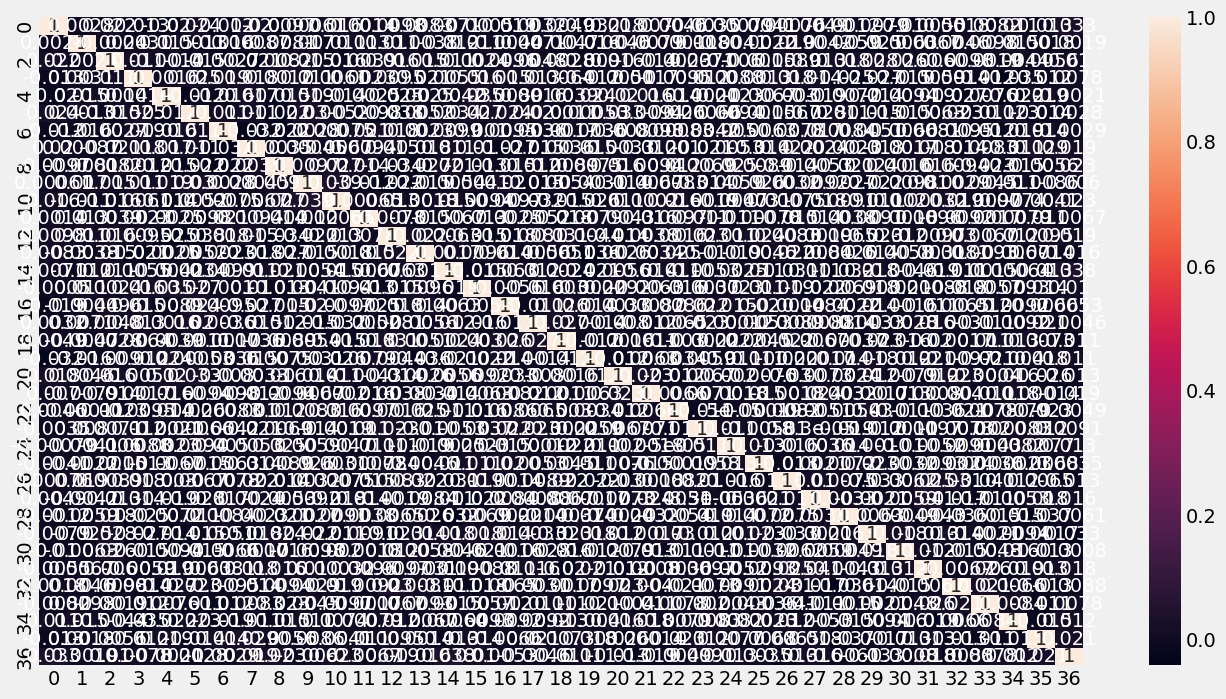

In [37]:
# Correlation heatmap of the components
df = pd.DataFrame.from_records(x_train)
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns


### Resampling the data using SMOTE

In [31]:
# Resampling the data using SMOTE (Synthetic Minority Over-sampling Technique)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Use sampling_strategy instead of ratio
sm = SMOTE(random_state=27, sampling_strategy='auto')
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


### Artificial Neural Network Model with K-Fold Cross-Validation using Custom Keras Classifier

In [23]:
from tensorflow import random
random.set_seed(101)
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Prepare your data (replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom wrapper to fit the Keras model to scikit-learn API
class KerasClassifier(BaseEstimator):
    def __init__(self, build_fn=None, epochs=10, batch_size=32):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
        return self
    
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)
    
    def score(self, X, y):
        return self.model.evaluate(X, y)[1]

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_classifier, epochs=40)
accuracies = cross_val_score(estimator=classifier, X=x_train_res, y=y_train_res, cv=5, n_jobs=-1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: " + str(mean))
print("Accuracy variance: " + str(variance))

# Print accuracy mean and variance as percentages
mean_percentage = mean * 100
variance_percentage = variance * 100

print(f"Accuracy mean: {mean_percentage:.2f}%")
print(f"Accuracy variance: {variance_percentage:.4f}%")



Accuracy mean: 0.8712499976158142
Accuracy variance: 0.01286954392869981
Accuracy mean: 87.12%
Accuracy variance: 1.2870%
